Notebook to generate some healpy maps of the data and associated random catalogues, to see how well the the generation of randoms and also sampling for completeness has worked. Also for a visualisation tool as to what the catalogues look like and how they are distributed.

In [1]:
%load_ext autoreload
%autoreload

# import modules
from importlib import reload

# import sys
# sys.path.append('../../clustering_pipeline/')
# # from imports import *
# from data_io import *

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from structures import catalogue_variables
from data_io import load_object, read_to_df
from aux import gen_fast_map

In [2]:
# the catalogue vars for the data sets we want to investigate
cat_vars_path = 'catalogue_vars/2021_05_catalogue_vars'
cat_vars = load_object(cat_vars_path)
cat_vars.__dict__

{'vars_name': '2021_05',
 'root_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/',
 'data_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/',
 'data_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/',
 'mask_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/survey_masks/',
 'randoms_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/randoms/',
 'randoms_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/randoms/',
 'results_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Input/',
 'results_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Output/',
 'plots_validation': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/plots_validation/2021_05/',
 'plots_results': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/plots_results/2021_05/',
 'catalogues': ['input', 'output'],
 'tracers': [

In [3]:
# main function for data validation and visualisation
def validate_catalogues(cat_vars, healpy_n=3):
    
    tracers = cat_vars.tracers
#     tracers = ['LyA'] # for quick testing
    
    for tracer in tracers:

        # load the data random catalogues
        df_in = read_to_df(cat_vars.data_input + 'input_reduced_' + tracer + '.fits')
        df_out = read_to_df(cat_vars.data_output + 'output_reduced_' + tracer + '.fits')
        df_rand_in = read_to_df(cat_vars.randoms_input + 'table_' + tracer + '.fits') # input randoms
        df_rand_out = read_to_df(cat_vars.randoms_output + 'table_' + tracer + '.fits') # output randoms

        # set up healpy pixels
        # healpy_n of 2 corresponds to a pixel with radius of ~ 0.7 deg and area of ~ 1.5 square deg
        nside = 12 * pow(healpy_n, 2)
        npixels = 12 * pow(nside, 2)

        # get pixel numbers (indices) of the data
        pixel_vals_in = hp.ang2pix(nside, df_in["RA"].values, df_in["DEC"].values, lonlat=True)
        pixel_vals_out = hp.ang2pix(nside, df_out["RA"].values, df_out["DEC"].values, lonlat=True)
        pixel_vals_rand_in = hp.ang2pix(nside, df_rand_in["RA"].values, df_rand_in["DEC"].values, lonlat=True)
        pixel_vals_rand_out = hp.ang2pix(nside, df_rand_out["RA"].values, df_rand_out["DEC"].values, lonlat=True)

        # get a hist of the redshift distribution
        z_bins = np.linspace(min(df_in['REDSHIFT_ESTIMATE'].values), max(df_in['REDSHIFT_ESTIMATE'].values), 100)
        z_bins_mid = 0.5*(z_bins[1:] + z_bins[:-1])
        hist_dat_in = np.histogram(df_in['REDSHIFT_ESTIMATE'].values, bins = z_bins)[0]
        hist_dat_out = np.histogram(df_out['REDSHIFT_ESTIMATE'].values, bins = z_bins)[0]
        hist_rand_in = np.histogram(df_rand_in['Z'].values, bins = z_bins)[0]
        hist_rand_out = np.histogram(df_rand_out['Z'].values, bins = z_bins)[0]

        # create healpy map of the data and randoms - the map is a 1d array where the index = pixel number,
        # and index value = points (i.e. galaxies) inside that pixel
        map_in = gen_fast_map(pixel_vals_in, npixels)
        map_out = gen_fast_map(pixel_vals_out, npixels)
        map_rand_in = gen_fast_map(pixel_vals_rand_in, npixels)
        map_rand_out = gen_fast_map(pixel_vals_rand_out, npixels)
        map_multiplier_in = np.divide(map_rand_in, map_in, out=np.zeros_like(map_rand_in, dtype=np.float64), where=map_in!=0)
        map_multiplier_out = np.divide(map_rand_out, map_out, out=np.zeros_like(map_rand_out, dtype=np.float64), where=map_out!=0)
        map_completeness = 100*np.divide(map_out, map_in, out=np.zeros_like(map_out, dtype=np.float64), where=map_in!=0)

        # get the random multiplier, then divide the random map by this then subtract the map to get residuals
        rand_multi_in = len(df_rand_in) / len(df_in)
        rand_multi_out = len(df_rand_out) / len(df_out)
        map_residuals_in = (map_rand_in / rand_multi_in) - map_in
        map_residuals_out = (map_rand_out / rand_multi_out) - map_out



        fig = plt.figure(figsize=(30, 20))

        # ********************************************************
        plt.subplot(3,3,1)
        hp.mollview(map_in, title="%s Input data map"%(tracer), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,2)
        hp.mollview(map_rand_in, title="%s Input random map"%(tracer), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,3)
        hp.mollview(map_residuals_in, title="Input %s residuals (randoms/rand_multi - data)"%(tracer), unit="Gal. density per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,4)
        hp.mollview(map_out, title="%s Output data map"%(tracer), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,5)
        hp.mollview(map_rand_out, title="%s Output random map"%(tracer), unit="Gal. density per pixel", hold=True)

        # ********************************************************
        plt.subplot(3,3,6)
        hp.mollview(map_residuals_out, title="Output %s residuals (randoms/rand_multi - data)"%(tracer), unit="Gal. density per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,7)
        hp.mollview(map_completeness, title="%s completeness (input data / output data)"%(tracer), unit="Completeness % per pixel", hold=True)
        
        # ********************************************************
        plt.subplot(3,3,8)
        plt.title('%s - Histogram of the redshift counts'%(tracer))
        plt.xlabel('Redshift')
        plt.ylabel('Number counts')
        plt.plot(z_bins_mid, hist_dat_in, marker='o', c='red', label='Input')
        plt.plot(z_bins_mid, hist_dat_out, marker='o', c='blue', label='Output')
        
        # ********************************************************
        plt.subplot(3,3,9)
        plt.title('%s - Histogram of the randoms multiplier amount per pixel'%(tracer))
        plt.xlabel('Randoms multiplier')
        plt.ylabel('Pixel counts')
        
        # for input
        bin_end = int(np.max(map_multiplier_in))
        bins = np.linspace(0, bin_end, bin_end+1)
        hist,bins = np.histogram(map_multiplier_in, bins=bins)
        bins_mid = 0.5*(bins[1:] + bins [:-1])
        plt.bar(np.delete(bins_mid,0), np.delete(hist,0), width=3, lw=2, alpha=0.6, color='red', label='Input')
        
        # for output
        bin_end = int(np.max(map_multiplier_out))
        bins = np.linspace(0, bin_end, bin_end+1)
        hist,bins = np.histogram(map_multiplier_out, bins=bins)
        bins_mid = 0.5*(bins[1:] + bins [:-1])
        plt.bar(np.delete(bins_mid,0), np.delete(hist,0), width=3, lw=2, alpha=0.3, color='blue', label='Output')
        
        plt.axvline(cat_vars.rand_multi, c='black', ls='--', label='Expected multiplier = %s'%(cat_vars.rand_multi))
        plt.legend()
        
        # ********************************************************

        plt.savefig(cat_vars.plots_validation + 'main_plots_' + tracer + '.png', dpi=150)
        plt.show()

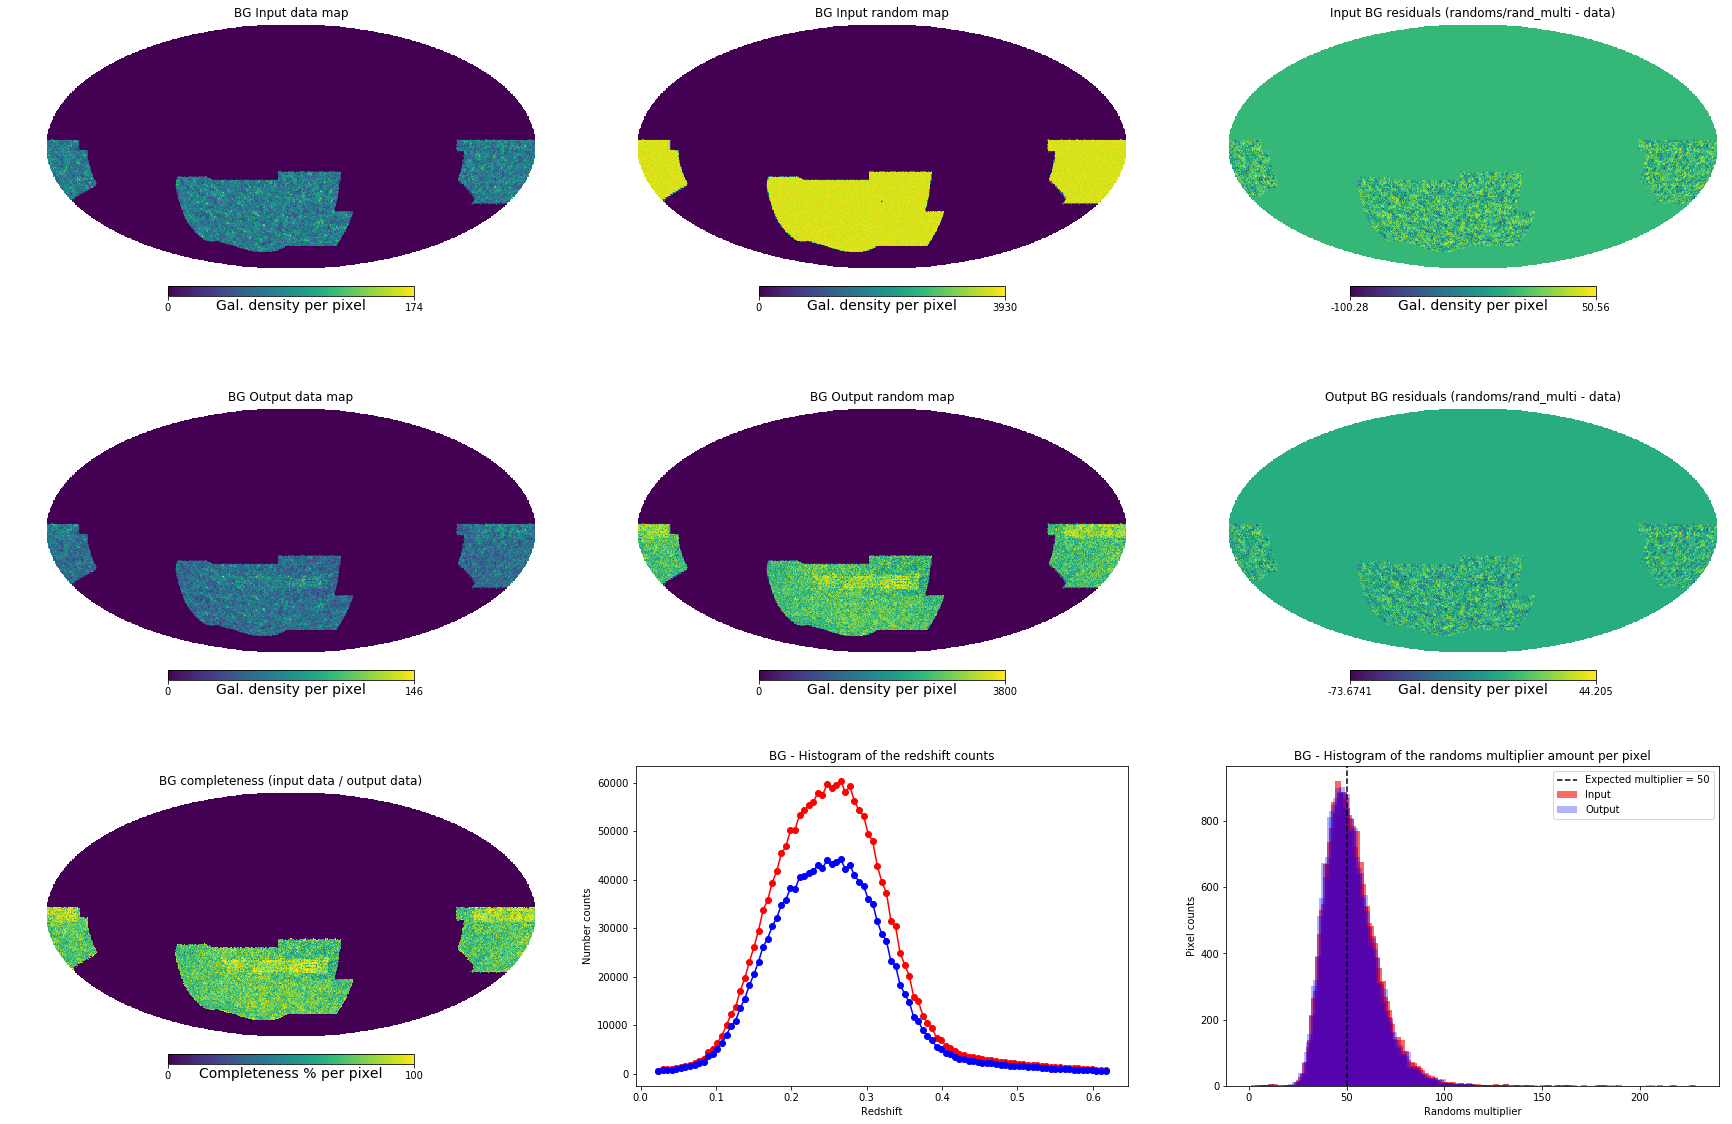

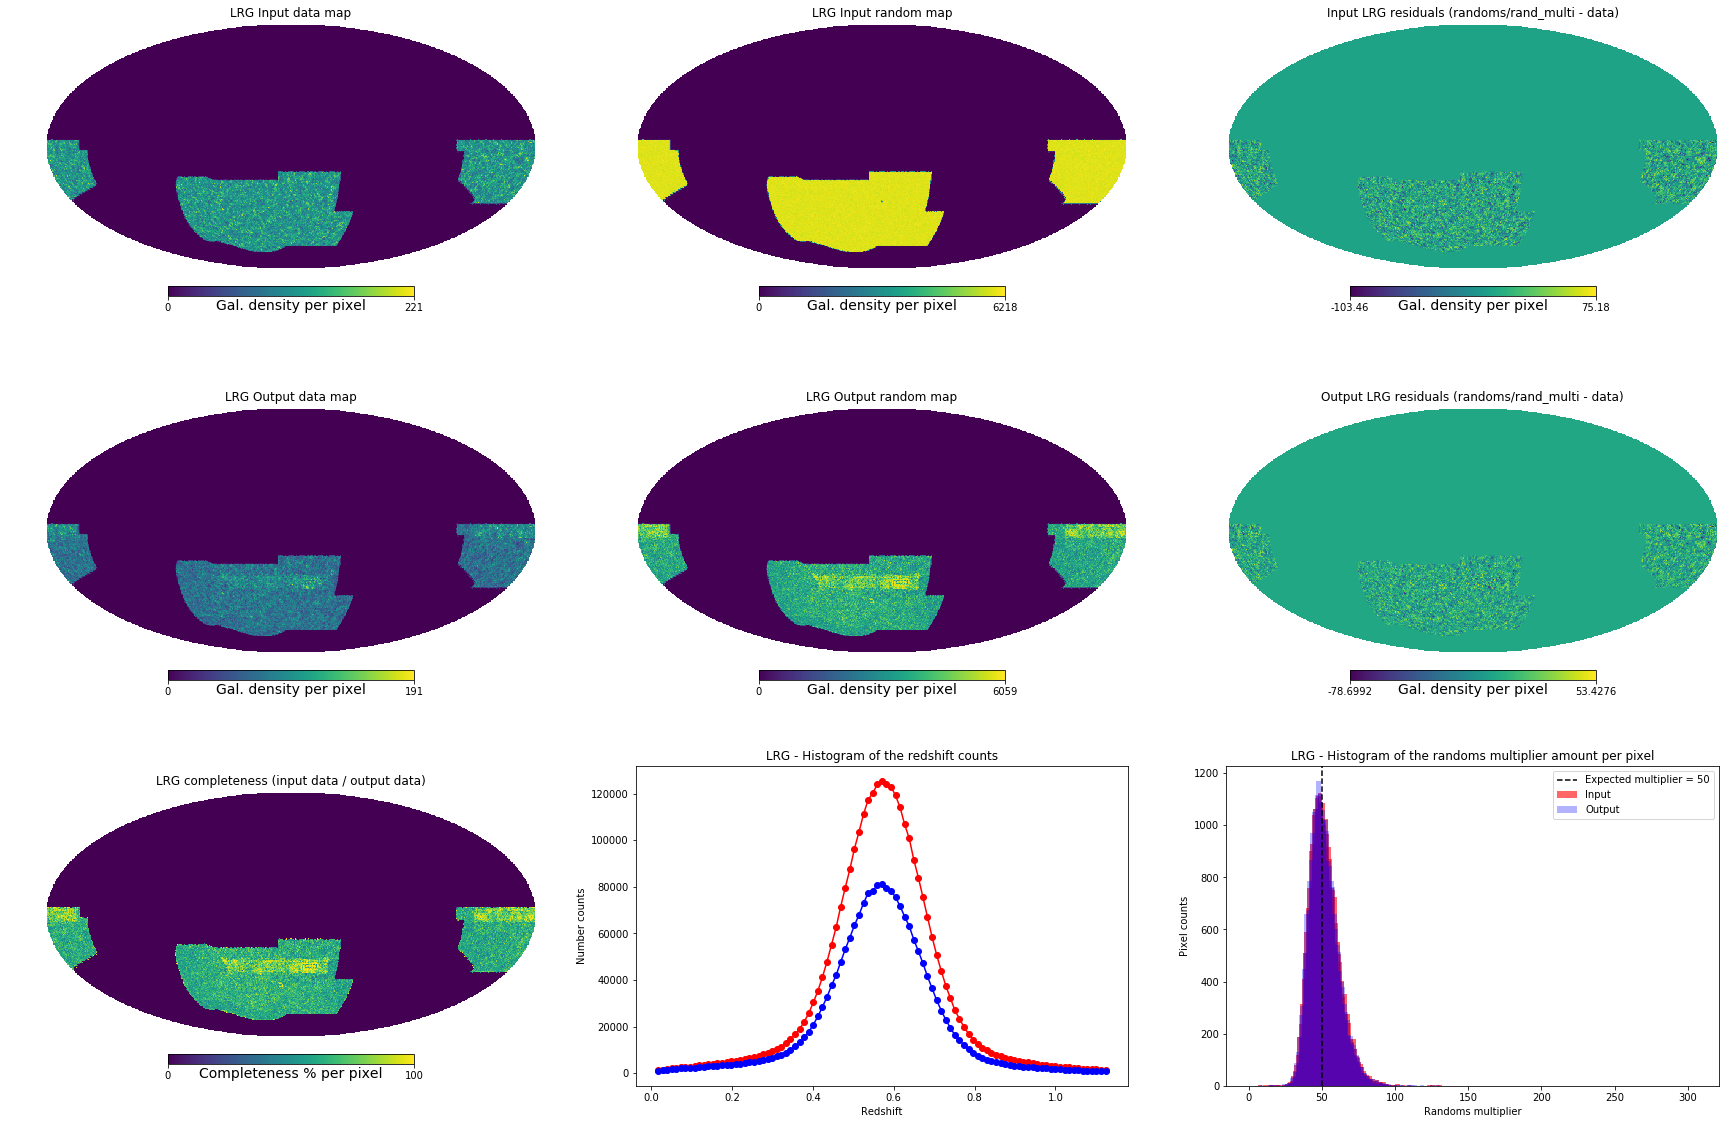

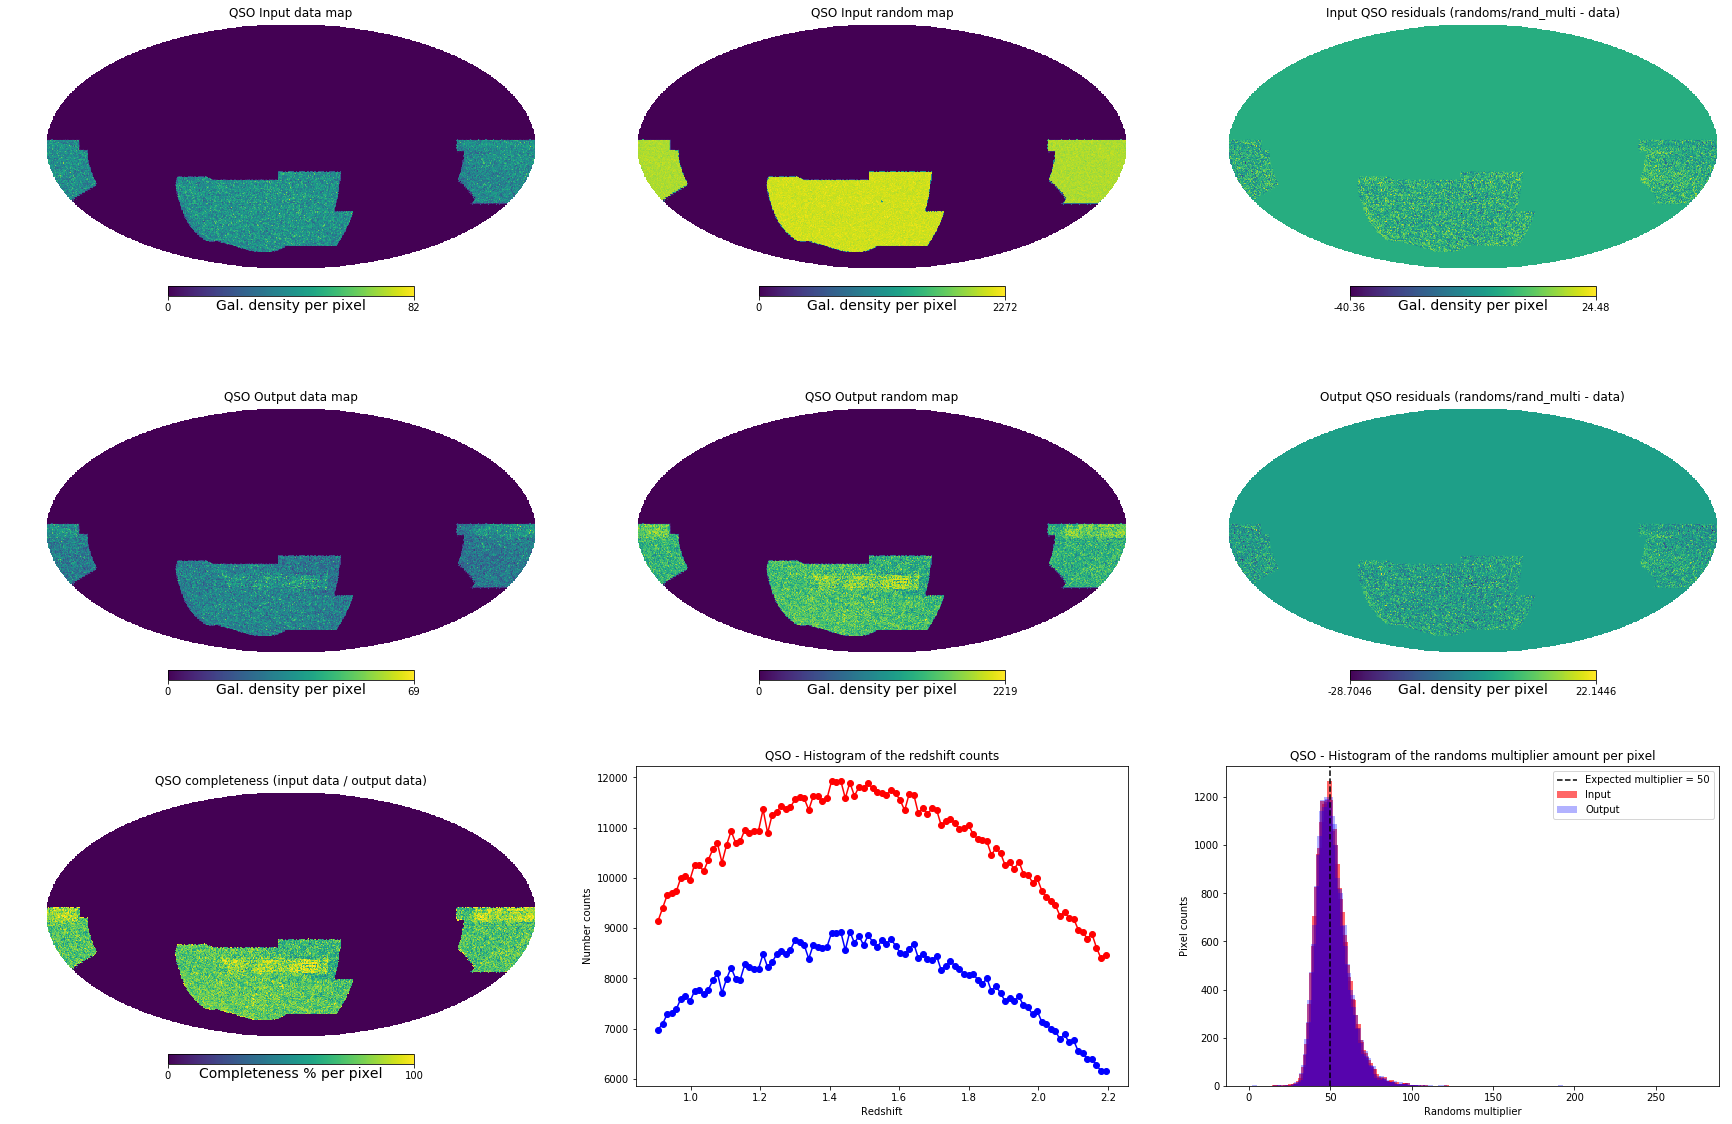

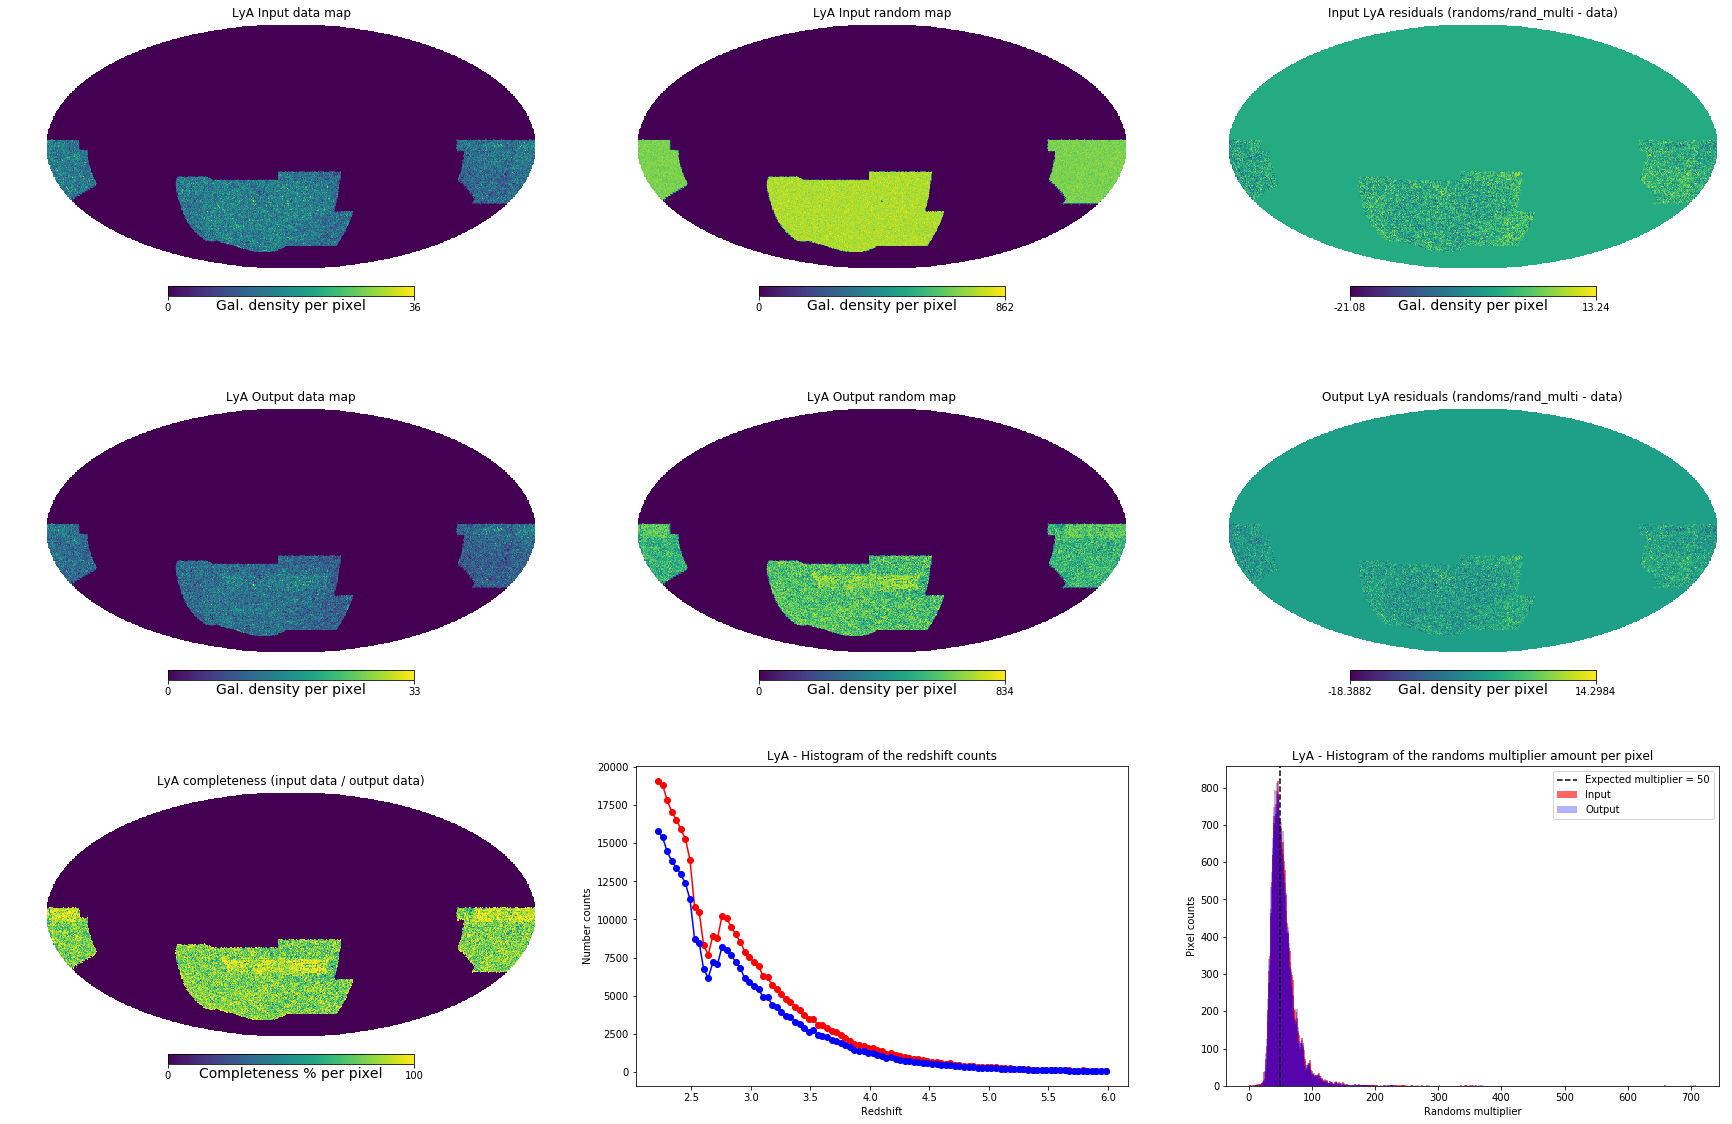

CPU times: user 2min 54s, sys: 1min 1s, total: 3min 56s
Wall time: 4min 58s


In [4]:
%%time

validate_catalogues(cat_vars, healpy_n=3)